# Objective: evaluate whether campaign goals are met.
## Task:  Did new creative increase conversions compared to the baseline creative?
#### No, the creative worsened the likelihood of conversion. 
#### The odds of conversion due to new creative was largely reduced instead of improving.


# Preparing the data

We will read two flat files that contain the campaign summary results, and desciptive features for the targeted users. Next, some data transformation maybe necessary. Statistical analysis will be performed to compare control to test groups. Some visualization will be performed for exploratory data analysis (EDA). First, load libraries needed to transform and analyze the data.

In [1]:
## load libraries
import pandas as pd # data manipulation
import seaborn as sns # data visualization
import numpy as np # data analysis
import matplotlib.pyplot as plt # data visualization
import scipy.stats as stats # statistical test
# produce plots
%matplotlib inline 
# set plotting style
plt.style.use('bmh')

In [2]:
# reading in the flat files
# for bid_requests
bid_requests = pd.read_csv('bid_requests.csv')
# for user_attributes.csv 
user_attributes = pd.read_csv('user_attributes.csv')

Take a look at the header if columns need re-formatting.

In [3]:
bid_requests.head()

,timestamp,user_id,bid,win,conversion
0,1/1/2017 0:00,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0
1,1/1/2017 0:00,26c5dca2512a4c7fe8810bd04191b1b3,0,0,0
2,1/1/2017 0:00,2121376a323507c01c5e92c39ae8ccd4,0,0,0
3,1/1/2017 0:00,fa6a0925d911185338b0acc93c66dc92,0,0,0
4,1/1/2017 0:00,4299f209da83da82b711f1d631cc607b,1,0,0


In [4]:
user_attributes.head()

,user_id,attributes
0,00003e3b9e5336685200ae85d21b4f5e,"{""age"": 33, ""gender"": ""F"", ""location"": ""FL"", ""..."
1,000053b1e684c9e7ea73727b2238ce18,"{""age"": 26, ""gender"": ""M"", ""location"": ""AL"", ""..."
2,00029153d12ae1c9abe59c17ff2e0895,"{""age"": 29, ""gender"": ""F"", ""location"": ""AR"", ""..."
3,0002ac0d783338cfeab0b2bdbd872cda,"{""age"": 29, ""gender"": ""M"", ""location"": ""SC"", ""..."
4,0004d0b59e19461ff126e3a08a814c33,"{""age"": 27, ""gender"": ""F"", ""location"": ""AR"", ""..."


Attributes is in a dictionary-structured string, 
split it into columns so the attributes can be explicitly used as features, then merge back the split columns to the bid_requests data frame.

In [5]:
# split it into columns so the attributes can be explicitly used as features
user_attributes = pd.concat([user_attributes, #concatenate to the original df user_attributes 
                      pd.DataFrame(list(user_attributes.attributes.map(eval)))], #the extracted attributes from dictionary
                            axis = 1) # to columns
# map the user features to the bid requests by joining the data frames on user_id
bid_requests_attributes = pd.merge(bid_requests, user_attributes,  # join the data frames
                                       on = 'user_id').drop(columns = 'attributes') # on user_id, and drop the attributes
bid_requests_attributes.head()

,timestamp,user_id,bid,win,conversion,age,gender,location,test
0,1/1/2017 0:00,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0,25,M,TN,1
1,1/1/2017 15:39,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0,25,M,TN,1
2,1/1/2017 18:44,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0,25,M,TN,1
3,1/2/2017 8:55,be7485be5b6eb3690efcbc9e95e8f15a,1,1,0,25,M,TN,1
4,1/2/2017 13:10,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0,25,M,TN,1


Let us look at the distribution of requests, and perform relevant exploratory data analysis (EDA). 

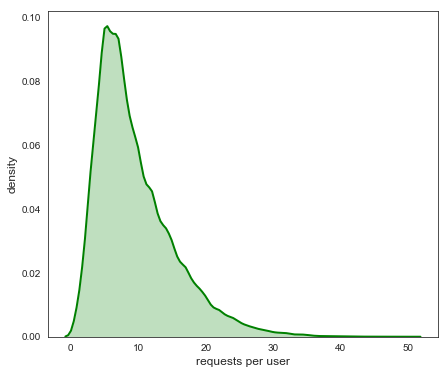

In [6]:
# plotting with seaborn
sns.set_style("white") # white background for contrast
plt.figure(figsize=(7, 6)) # adjust figure size
# Plot a filled kernel density estimate
x = sns.distplot(bid_requests_attributes['user_id'].value_counts(), 
                 hist=False, color="g", kde_kws={"shade": True})
x.set(xlabel='requests per user', ylabel='density');  # adjust label name


This is a positive-skew distribution, which means the mean is higher than the median.

Let us assess whether there is an enrichment of conversion in the test group compared to control. Since we are comparing counts, we can use the Fischer exact test. Our target variable is the user_id, so we need to add segment that column by conversion and testing. The criterion for conversion is that there is at least one conversion event. 

In [8]:
# only keep the won bids
bid_requests_attributes_won = bid_requests_attributes[bid_requests_attributes['win'] == 1]
# make the conversion to customer_id one-to-one relationship
bid_requests_attributes_won_sorted = bid_requests_attributes_won.sort_values(by = ['user_id','conversion'], 
                                        ascending= [False, False]).drop_duplicates(subset = 'user_id', keep = 'first')

In [17]:
bid_requests_attributes_won_sorted[(bid_requests_attributes_won_sorted.conversion) ==1].user_id.nunique

<bound method IndexOpsMixin.nunique of 349641    ffed58af1486d55983158acee38bdea2
583123    ffd8c24f180b4ba8a2bc58a6c81c7210
463196    ffcf3174be79160cd4f3eb50bc76d034
384230    ffc937399e9985e3399dbff1e4f6fd96
208662    ffafba921b7b509985a9ab639d63ffd4
                        ...               
101873    003da94355a506f1f294090c173e7b73
411125    003bed21fddc817050c8fa11897fe660
444747    003ae4e8b9f59b0aa0910ba1f5e35735
513042    002572981e2eebd53b48809982cd3684
368918    0007cda84fafdcf42f96c4f4adb7f8ce
Name: user_id, Length: 5607, dtype: object>

In [45]:
# only keep the won bids
bid_requests_attributes_won = bid_requests_attributes[bid_requests_attributes['win'] == 1]# make the
#conversion to customer_id one-to-one relationship
bid_requests_attributes_won_sorted = bid_requests_attributes_won.sort_values(by = ['user_id','conversion'], 
                                        ascending= [False, False]).drop_duplicates(subset = 'user_id', keep = 'first')
# get the test/conversion 2X2 array combinations

# conversion = 1, test = 1
con_test = bid_requests_attributes_won[(bid_requests_attributes_won['conversion'] == 1) & (
                                                  bid_requests_attributes_won['test'] == 1)].user_id.nunique()
# conversion = 0, test = 1
nocon_test = bid_requests_attributes_won[(bid_requests_attributes_won['conversion'] == 0)&(
                                                    bid_requests_attributes_won['test'] == 1)].user_id.nunique()
# conversion = 1, test = 0
con_notest = bid_requests_attributes_won[(bid_requests_attributes_won['conversion'] == 0)&(
                                                    bid_requests_attributes_won['test'] == 1)].user_id.nunique()
# conversion = 1, test = 0
nocon_notest = bid_requests_attributes_won[(bid_requests_attributes_won['conversion'] == 0) &(
                                                      bid_requests_attributes_won['test'] == 0)].user_id.nunique()


In [46]:
print("not tested and not converted", nocon_notest)
print("not tested and converted", con_notest)
print("tested and converted", con_test)
print("tested and not converted", con_notest)

not tested and not converted 23096
not tested and converted 29716
tested and converted 3112
tested and not converted 29716


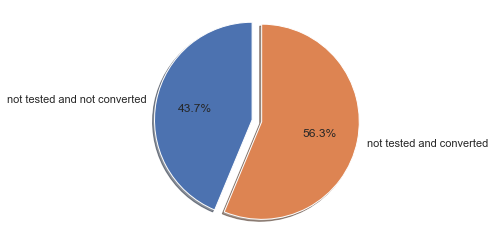

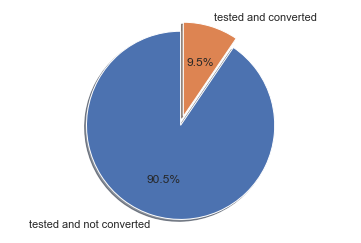

In [47]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels_not = 'not tested and not converted', 'not tested and converted'
sizes_not = [nocon_notest, con_notest]
explode_not = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

labels = 'tested and not converted', 'tested and converted'
sizes = [nocon_test, con_test]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

ax1.pie(sizes_not, explode=explode_not, labels=labels_not, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.show()
plt.show()

In [48]:
# Apply Fischer's exact test to get an estimate of enrichment in conversion due to new creative
oddsratio, pvalue = stats.fisher_exact([ [nocon_notest, con_notest],[nocon_test, con_test]])

print("oddsratio", oddsratio)
print("pvalue", pvalue)


oddsratio 0.08139461248090031
pvalue 0.0


oddsratio << 1, overall the creative seems not to work. This test is sub-population agnostic. The next of anlaysis would be to test if the creative was specifically effective within a particular population group.